In [1]:
import pandas as pd
import numpy as np

import json
import functools as ft
import itertools as it

%matplotlib inline
import matplotlib.pyplot as plt

In [11]:
louv = pd.read_csv('../results/weighted/louvain_clusters.txt', index_col=0, header=0, sep='\t')
louv.columns = ['cluster_super']
louv = louv.merge(pd.read_csv('../results/weighted/louvain_small_clusters.txt', index_col=0, header=0, sep='\t'), left_index=True, right_index=True)
louv.columns = ['cluster_super', 'cluster_sub']
louv.head()

,cluster_super,cluster_sub
names,,
MST1R,3,11
YES1,3,11
TYRO3,3,11
FGR,3,11
SRC,3,11


In [21]:
enst_to_hgnc = pd.read_csv('../data/ref/ensdb.hsapiens.v86.mapping.csv', index_col=0)['name'].to_dict()
next(iter(enst_to_hgnc.items()))

('ENST00000456328', 'DDX11L1')

In [34]:
# read in file
trametinib_100nm_rep_1 = pd.read_csv('../data/exper/salmon_alignment/SUM159_100nM_trametinib_24h_replicate1.fastq.gz/quant.sf', sep='\t')

# map to hgnc
trametinib_100nm_rep_1['hgnc'] = trametinib_100nm_rep_1['Name'].apply(lambda x: enst_to_hgnc[x.split('.')[0]] if x.split('.')[0] in enst_to_hgnc.keys() else None)

# groupby
trametinib_100nm_rep_1 = trametinib_100nm_rep_1.groupby('hgnc').agg({'Length':np.sum, 'EffectiveLength':np.sum, 'TPM':np.sum, 'NumReads':np.sum})

# display
trametinib_100nm_rep_1.head()

,Length,EffectiveLength,TPM,NumReads
hgnc,,,,
5S_rRNA,102,4.543,0.000000,0.000
A1BG,7549,6304.000,14.366165,184.284
A1CF,46436,43946.000,0.000000,0.000
A2M,11826,8589.000,0.000000,0.000
A2ML1,15888,13647.000,0.010659,2.000


In [39]:
from copy import copy
louv_trametinib_100nm_rep_1 = copy(louv.merge(trametinib_100nm_rep_1, how='left', left_index=True, right_index=True))
print('Number of missing kinases:', np.sum(np.isnan(louv_trametinib_100nm_rep_1.NumReads)))
louv_trametinib_100nm_rep_1.head()

Number of missing kinases: 5


,cluster_super,cluster_sub,Length,EffectiveLength,TPM,NumReads
names,,,,,,
MST1R,3,11,31846.0,28111.012,0.704130,21.000
YES1,3,11,14689.0,13444.000,21.955303,4383.699
TYRO3,3,11,18570.0,16305.000,30.941734,2228.421
FGR,3,11,12147.0,10404.000,0.412503,27.000
SRC,3,11,23509.0,20770.000,21.432630,1920.000


In [40]:
# read in file
dmso_rep_1 = pd.read_csv('../data/exper/salmon_alignment/SUM159_DMSO_24h_replicate1.fastq.gz/quant.sf', sep='\t')

# map to hgnc
dmso_rep_1['hgnc'] = dmso_rep_1['Name'].apply(lambda x: enst_to_hgnc[x.split('.')[0]] if x.split('.')[0] in enst_to_hgnc.keys() else None)

# groupby
dmso_rep_1 = dmso_rep_1.groupby('hgnc').agg({'Length':np.sum, 'EffectiveLength':np.sum, 'TPM':np.sum, 'NumReads':np.sum})

# display
dmso_rep_1.head()

,Length,EffectiveLength,TPM,NumReads
hgnc,,,,
5S_rRNA,102,4.543,0.000000,0.000
A1BG,7549,6304.000,4.878696,77.006
A1CF,46436,43946.000,0.000000,0.000
A2M,11826,8589.000,0.000000,0.000
A2ML1,15888,13647.000,0.000000,0.000


In [41]:
from copy import copy
louv_dmso_rep_1 = copy(louv.merge(dmso_rep_1, how='left', left_index=True, right_index=True))
print('Number of missing kinases:', np.sum(np.isnan(louv_dmso_rep_1.NumReads)))
louv_dmso_rep_1.head()

Number of missing kinases: 5


,cluster_super,cluster_sub,Length,EffectiveLength,TPM,NumReads
names,,,,,,
MST1R,3,11,31846.0,28111.012,0.430174,7.000
YES1,3,11,14689.0,13444.000,27.096279,6530.470
TYRO3,3,11,18570.0,16305.000,25.743389,2074.221
FGR,3,11,12147.0,10404.000,0.000000,0.000
SRC,3,11,23509.0,20770.000,13.484501,1392.000


In [51]:
fold_change = np.round(np.log(list(map(lambda x: x[0]/x[1] if x[0] != 0 and x[1] != 0 else 1 if x[0] is not np.nan and x[1] is not np.nan else np.nan, zip(louv_trametinib_100nm_rep_1.TPM, louv_dmso_rep_1.TPM)))), 3)
louv['fold_change'] = fold_change
louv.head()

,cluster_super,cluster_sub,fold_change
names,,,
MST1R,3,11,0.493
YES1,3,11,-0.210
TYRO3,3,11,0.184
FGR,3,11,0.000
SRC,3,11,0.463


In [55]:
louv.fold_change[louv.fold_change.isna()]

names
MAP3K20   NaN
SGK196    NaN
HASPIN    NaN
MAP3K21   NaN
PRAG1     NaN
Name: fold_change, dtype: float64

In [58]:
louv_fold = louv[louv.columns[-1:]]
louv_fold.to_csv('../viz/js/circle_pack_viz/dist/viz_fold.json')

/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


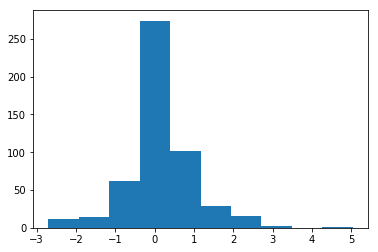

In [52]:
plt.hist(list(filter(lambda x: x is not np.nan, louv.fold_change)))
plt.show()